# VarClump3D: Concept test on Orion

In [1]:
%matplotlib inline

import sys
import numba
import time
import numpy as np
import numpy.ma as ma
import scipy as sp
import sympy as sym
import numexpr as ne
from math import exp, sqrt, log, floor, ceil
from threading import Thread
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact, interactive, fixed

#from mayavi import mlab

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils3D import *
from graph import *
from points_generation3D import *
from initial_guess3D import *
from variational3D import *
#from gmr import *

# extra metric module
#import custom_metric as cm

## Loading 3D data

In [2]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'

x, y, z, data, dfunc = load_data(fit_path)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


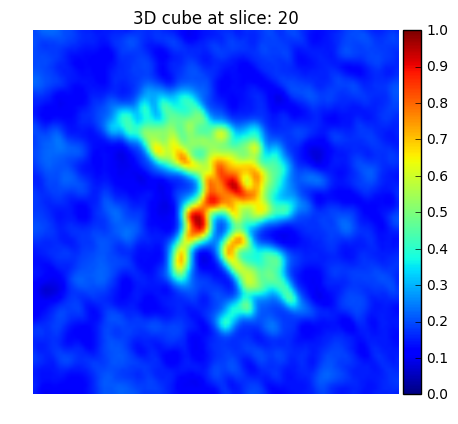

<function graph.slices_plot>

In [3]:
interact(slices_plot, data=fixed(data), slc=(0, data.shape[0]-1))

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^3} L(x, y, z, u, u_x, u_y, u_z) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^3}(u(x,y,z)-f_0(x,y,z))^2 + \alpha \ \Psi_1(u(x,y,z)-f_0(x,y,z)) + \beta \ \Psi_2(\left|\nabla u(x,y,z)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y} -  \frac{d}{dz}\frac{\partial L}{\partial u_z}= 0$$

**2D case**:
$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

**3D case**:
$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y,z) = \sum_{i=1}^N c_i \ \phi(x, y, z;\ x_i, y_i, z_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}{2 \sigma_i^2}}$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

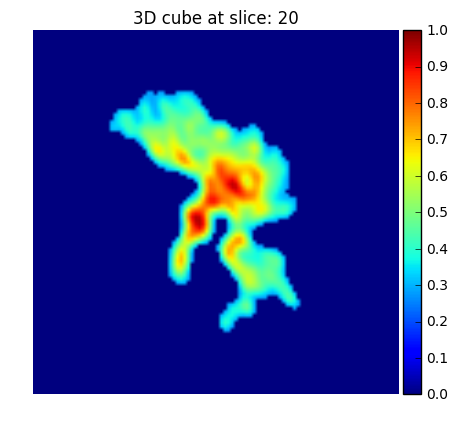

<function graph.slices_plot>

In [4]:
base_level = 1.5*estimate_rms(data)
_data = np.copy(data)
mask = data > base_level
_data[~mask] = 0. 
interact(slices_plot, data=fixed(_data), slc=(0, _data.shape[0]-1))

## Experiments 1: Random sampled Gaussian centers
The following instances test with different settings combinations for the number of centers

## `500 centers`

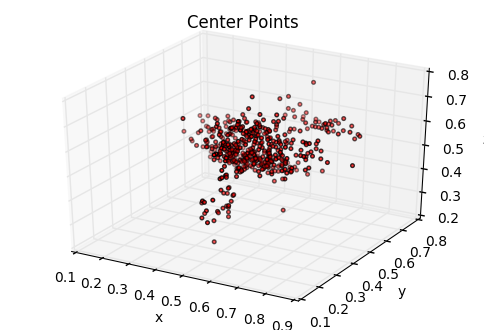

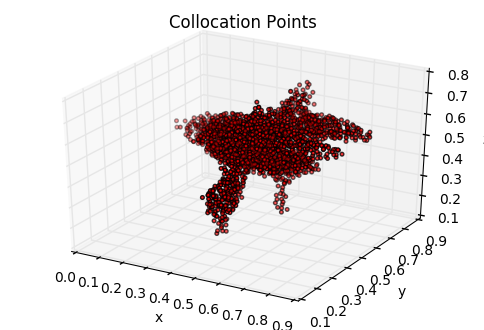

In [5]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 500
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
points_plot3D(center_points, title='Center Points')
points_plot3D(collocation_points, title='Collocation Points')

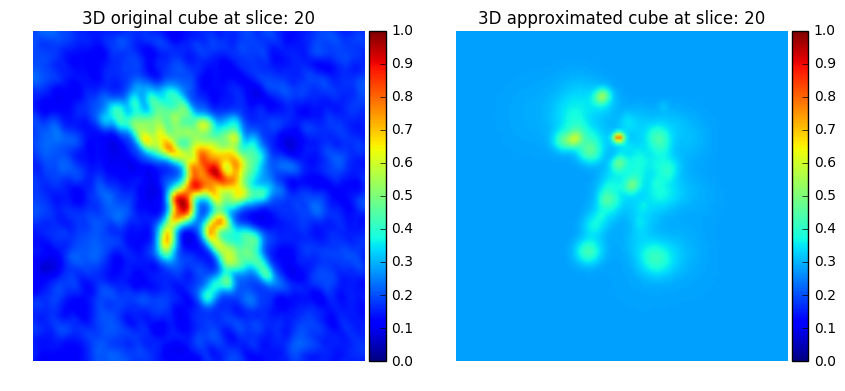

<function graph.comparative_slices_plot>

In [9]:
# initial parameters estimation
minsig = ( (1./data.shape[0] + 1./data.shape[1] + 1./data.shape[2])/3. ) / 6.
maxsig = 30*minsig
dist_matrix = build_dist_matrix(center_points) 
c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

# visualization
u0_sol = compute_solution(c0, sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

In [10]:
# ELModel instantiation
elm01 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

../lib/utils3D.py:135: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:

success: False

status: 5

message: Number of calls to function has reached maxfev = 20000.

nfev: 20012
Residual RMS: 0.297552048754
Residual Variance: 0.0022627448283
Residual Entropy: 6.52763980673
Total elapsed time: 486.053362131 [s]


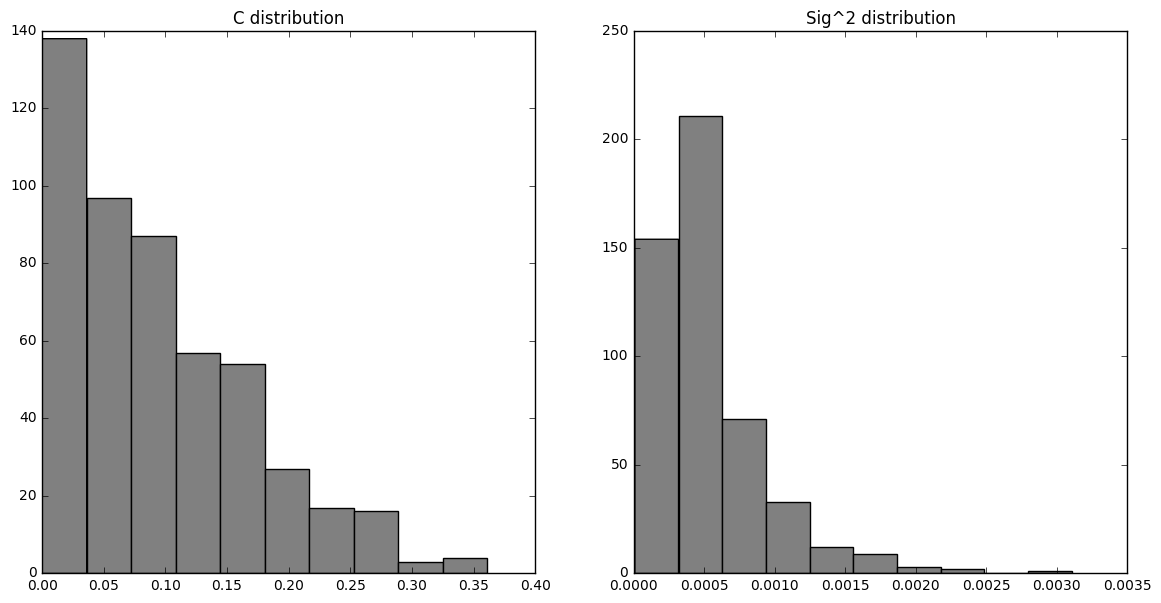

In [12]:
    elm_solver(elm01, method='standar', max_nfev=20000)

In [17]:
pickle.dump(elm01, open('elm01.pkl', 'wb'))
elm01 = pickle.load(open('elm01.pkl', 'rb'))

## `1000 centers`

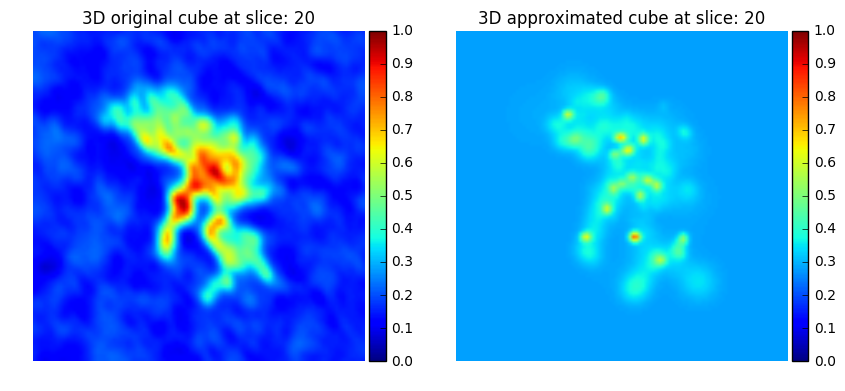

/home/mavillan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: overflow encountered in exp



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:

success: False

status: 5

message: Number of calls to function has reached maxfev = 50000.

nfev: 50015
Residual RMS: 0.292234710764
Residual Variance: 0.000876969442788
Residual Entropy: 6.56800600623
Total elapsed time: 3425.37280703 [s]


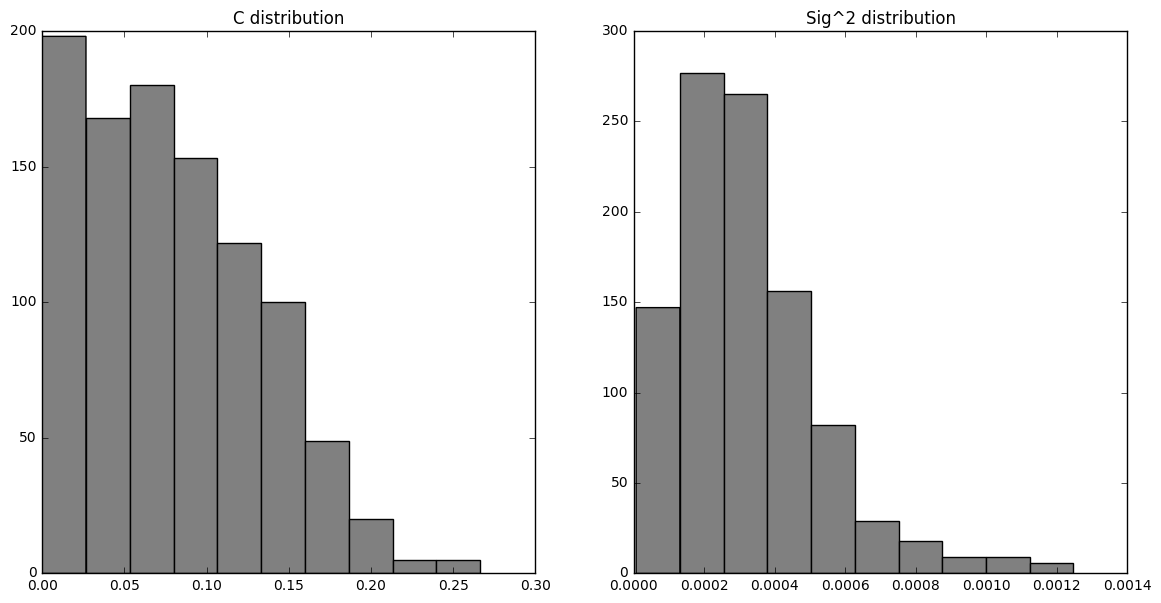

In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 1000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(c0, sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm02 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1)

elm_solver(elm02, method='standar', max_nfev=50000)

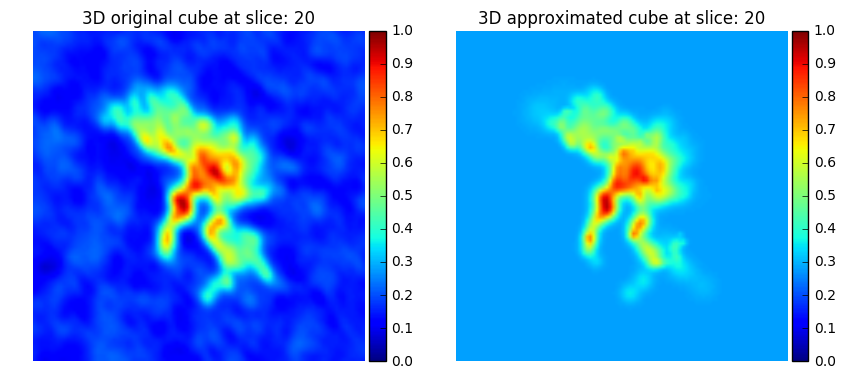

<function __main__.comparative_slices_plot>

In [ ]:
# visualization of solution
xc, yc, zc, c, sig = elm02.get_params_mapped()
u_sol = compute_solution(c, sig, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `2000 centers`

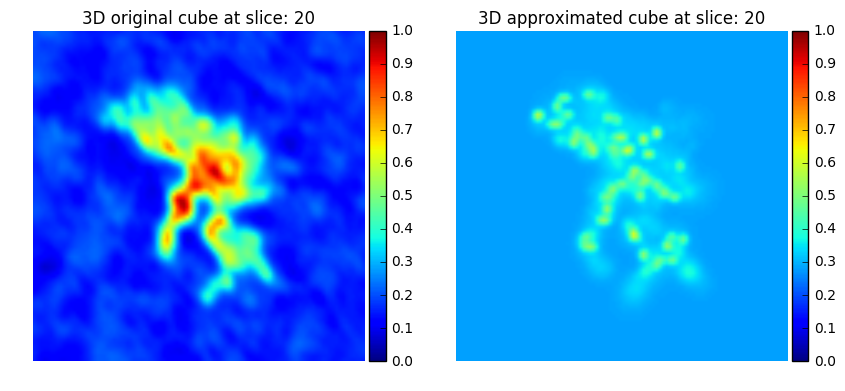

In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 2000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(c0, sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm03 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1)

elm_solver(elm03, method='standar', max_nfev=50000)

In [ ]:
# visualization of solution
xc, yc, zc, c, sig = elm03.get_params_mapped()
u_sol = compute_solution(c, sig, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `3000 centers`

In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 3000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(c0, sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm04 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1)

elm_solver(elm04, method='standar', max_iter=50000)

In [ ]:
# visualization of solution
xc, yc, zc, c, sig = elm04.get_params_mapped()
u_sol = compute_solution(c, sig, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

## `4000 centers`

In [ ]:
##########################################
# Approach 1
##########################################

base_level = 1.5*estimate_rms(data)

# number of points of each type
Nb = 0
Nc = 4000
Ne = 5*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=3)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]
xb = np.empty(Nb)
yb = np.empty(Nb)
zb = np.empty(Nb)

# visualization of points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()


# initial parameters estimation
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
Dz = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
    Dz[k,:] = zc[k]-zc
dist_matrix = np.sqrt(Dx**2+Dy**2+Dz**2)

c0, sig0 = estimate_initial_guess(center_points, dist_matrix, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

# visualization of initial guess
u0_sol = compute_solution(c0, sig0, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u0_sol+base_level), slc=(0, _data.shape[0]-1))

# ELModel instantiation
elm05 = ELModel(data, dfunc, data.shape, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1)

elm_solver(elm05, method='standar', max_nfev=50000)

In [ ]:
# visualization of solution
xc, yc, zc, c, sig = elm02.get_params_mapped()
u_sol = compute_solution(c, sig, xc, yc, zc, dims=data.shape)
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))